# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Create-the-two-ScatterNets" data-toc-modified-id="Create-the-two-ScatterNets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create the two ScatterNets</a></div><div class="lev1 toc-item"><a href="#Stability-to-noise" data-toc-modified-id="Stability-to-noise-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Stability to noise</a></div><div class="lev1 toc-item"><a href="#Stability-to-Shifts" data-toc-modified-id="Stability-to-Shifts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stability to Shifts</a></div><div class="lev1 toc-item"><a href="#Stability-to-Deformations" data-toc-modified-id="Stability-to-Deformations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stability to Deformations</a></div>

This notebook quantifies how stable the DTCWT and Morlet based scatternets are to noise, shifts, and deformation

In [1]:
from kymatio import Scattering2D
import torch
from pytorch_wavelets import ScatLayer, ScatLayerj2
import numpy, elasticdeform

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import dtcwt_gainlayer.data.tiny_imagenet as ti

In [4]:
trainloader, testloader = ti.get_data(64, data_dir='/scratch/share/Tiny_ImageNet/', val_only=True)

| loaded tiny imagenet

In [5]:
# Get some image data. Let us use some tiny_imagenet images
data = []
for i, x in enumerate(testloader):
    if i == 10:
        break
    data.append(x[0])
data = torch.cat(data, dim=0)
print(data.shape)

torch.Size([1280, 3, 64, 64])


In [6]:
class Scat2D(torch.nn.Module):
    """ A wrapper around KyMatIO's ScatterNet"""
    def __init__(self):
        super().__init__()
        self.scat = Scattering2D(J=2, shape=(64, 64), L=6).cuda()
        
    def forward(self, x):
        x = self.scat(x)
        return x.view(x.shape[0], -1, x.shape[3], x.shape[4])

# Create the two ScatterNets
For the DTCWT, we test over some of the options

In [7]:
scat_morlet = Scat2D()
scatA = torch.nn.Sequential(ScatLayer(magbias=0.0, biort='near_sym_b', mode='symmetric'), ScatLayer(magbias=0.0, biort='near_sym_b', mode='symmetric')).cuda()
scatB = torch.nn.Sequential(ScatLayer(magbias=0.0, biort='near_sym_a', mode='zero'), ScatLayer(magbias=0.0, biort='near_sym_a', mode='zero')).cuda()
scatC = ScatLayerj2(biort='near_sym_b', qshift='qshift_b').cuda()
x = data

In [8]:
Sx = scat_morlet(x.cuda())
Dax = scatA(x.cuda())
Dbx = scatB(x.cuda())
Dcx = scatC(x.cuda())

# Stability to noise

In [188]:
n = 0.7*torch.randn_like(x)
Sxn = scat_morlet((x+n).cuda())
Daxn = scatA((x+n).cuda())
Dbxn = scatB((x+n).cuda())
Dcxn = scatC((x+n).cuda())

In [189]:
print('For an additive noise with σ=0.7 ({:.0f}% the input energy), we have:'.format(100*(n**2).sum()/(x**2).sum()))
print("|x-x'|^2 is {:.3f}".format(torch.mean((n**2))))
print("|Sx-Sx'|^2 for Morlet Scat is {:.3f}".format(torch.mean((Sx-Sxn)**2)))
print("|Sx-Sx'|^2 for DTCWT Scat A is {:.3f}".format(torch.mean((Dax-Daxn)**2)))
print("|Sx-Sx'|^2 for DTCWT Scat B is {:.3f}".format(torch.mean((Dbx-Dbxn)**2)))
print("|Sx-Sx'|^2 for DTCWT Scat C is {:.3f}".format(torch.mean((Dcx-Dcxn)**2)))

For an additive noise with σ=0.7 (38% the input energy), we have:
|x-x'|^2 is 0.490
|Sx-Sx'|^2 for Morlet Scat is 0.003
|Sx-Sx'|^2 for DTCWT Scat A is 0.030
|Sx-Sx'|^2 for DTCWT Scat B is 0.029
|Sx-Sx'|^2 for DTCWT Scat C is 0.046


# Stability to Shifts

In [174]:
y = torch.roll(x, (2, 2), dims=(2,3))
Sy = scat_morlet(y.cuda())
Day = scatA(y.cuda())
Dby = scatB(y.cuda())
Dcy = scatC(y.cuda())

In [178]:
print('For a shift of 2 pixels right and 2 down, we have:')
print("|x-x'|^2 is {:.3f}".format(torch.mean((y-x)**2)))
print("|Sx-Sx'|^2 for Morlet Scat is {:.3f}".format(torch.mean((Sx-Sy)**2)))
print("|Sx-Sx'|^2 for DTCWT Scat A is {:.3f}".format(torch.mean((Dax-Day)**2)))
print("|Sx-Sx'|^2 for DTCWT Scat B is {:.3f}".format(torch.mean((Dbx-Dby)**2)))
print("|Sx-Sx'|^2 for DTCWT Scat C is {:.3f}".format(torch.mean((Dcx-Dcy)**2)))

For a shift of 2 pixels right and 2 down, we have:
|x-x'|^2 is 0.740
|Sx-Sx'|^2 for Morlet Scat is 0.004
|Sx-Sx'|^2 for DTCWT Scat A is 0.009
|Sx-Sx'|^2 for DTCWT Scat B is 0.009
|Sx-Sx'|^2 for DTCWT Scat C is 0.030


# Stability to Deformations

In [22]:
σ = 3
z = torch.tensor(elasticdeform.deform_random_grid(x.numpy(), sigma=σ, axis=(2,3)))
Sz = scat_morlet(z.cuda())
Daz = scatA(z.cuda())
Dbz = scatB(z.cuda())
Dcz = scatC(z.cuda())

In [23]:
print('For a random deformation with σ=5 we have:')
print("|x-x'|^2 is {:.3f}".format(torch.mean((z-x)**2)))
print("|Sx-Sx'|^2 for Morlet Scat is {:.3f}".format(torch.mean((Sz-Sx)[:, :, 2*σ:-2*σ]**2)))
print("|Sx-Sx'|^2 for DTCWT Scat A is {:.3f}".format(torch.mean((Daz-Dax)[:, :, 2*σ:-2*σ]**2)))
print("|Sx-Sx'|^2 for DTCWT Scat B is {:.3f}".format(torch.mean((Dbz-Dbx)[:, :, 2*σ:-2*σ]**2)))
print("|Sx-Sx'|^2 for DTCWT Scat C is {:.3f}".format(torch.mean((Dcz-Dcx)[:, :, 2*σ:-2*σ]**2)))

For a random deformation with σ=5 we have:
|x-x'|^2 is 0.667
|Sx-Sx'|^2 for Morlet Scat is 0.004
|Sx-Sx'|^2 for DTCWT Scat A is 0.011
|Sx-Sx'|^2 for DTCWT Scat B is 0.010
|Sx-Sx'|^2 for DTCWT Scat C is 0.032


<IPython.core.display.Javascript object>


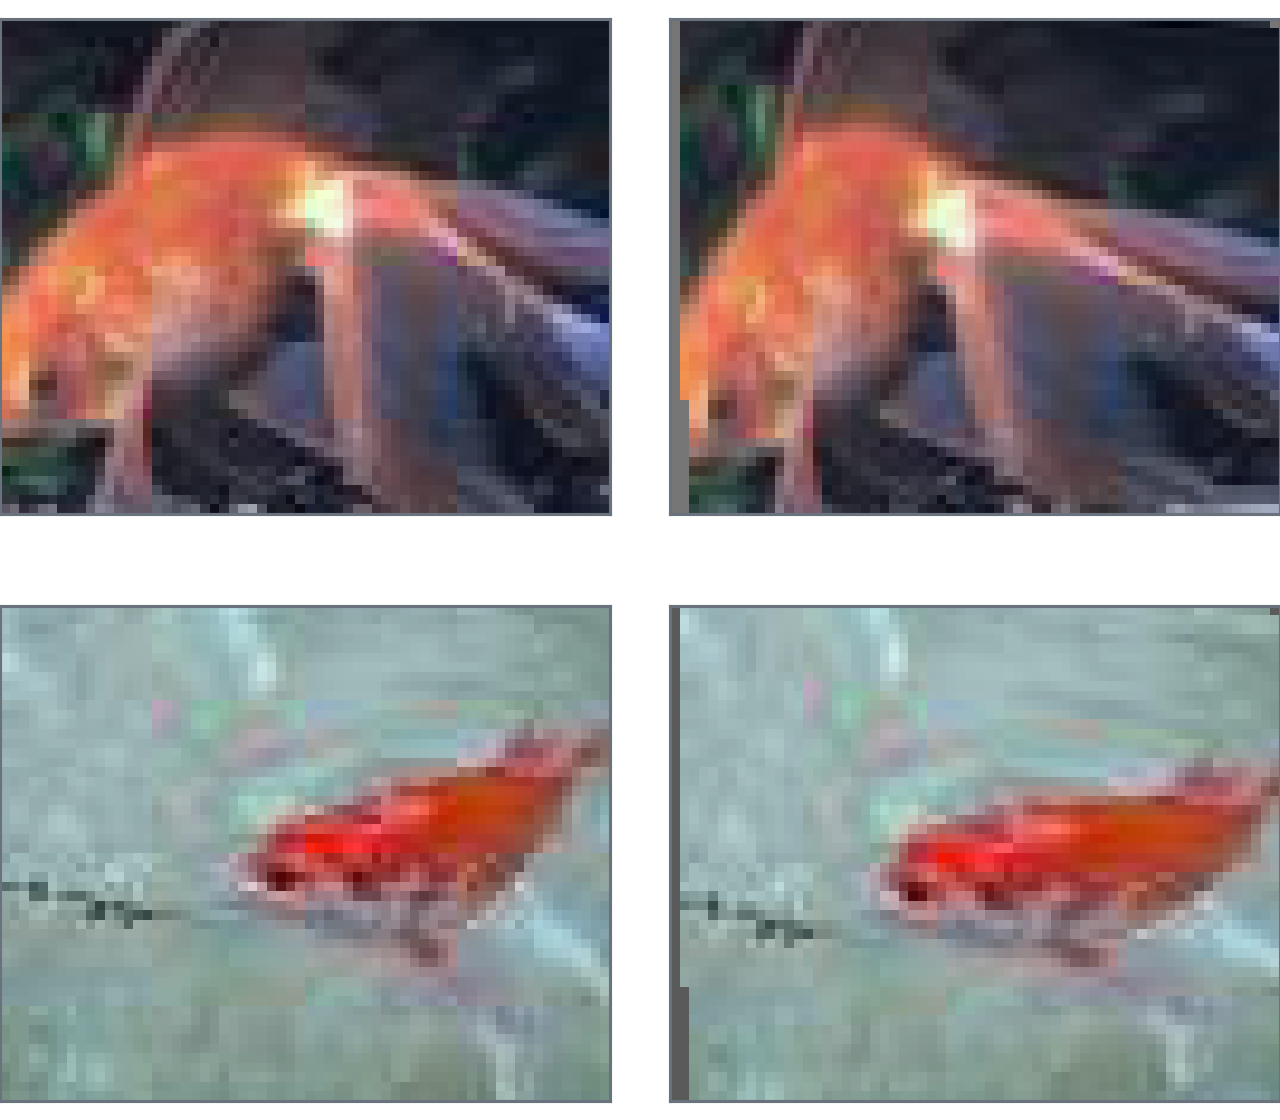

In [24]:
import plotters  # https://github.com/fbcotter/plotters
fig, ax = plt.subplots(2,2, gridspec_kw=dict(hspace=0.1, wspace=0.1, left=0., right=1, top=1,bottom=0), 
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0,0].imshow(plotters.normalize(x[0, :, 2*σ:-2*σ].numpy().transpose(1,2,0)))
ax[0,1].imshow(plotters.normalize(z[0, :, 2*σ:-2*σ].numpy().transpose(1,2,0)))
ax[1,0].imshow(plotters.normalize(x[1, :, 2*σ:-2*σ].numpy().transpose(1,2,0)))
ax[1,1].imshow(plotters.normalize(z[1, :, 2*σ:-2*σ].numpy().transpose(1,2,0)))